# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

## Importing the libraries :

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support

## Loading dataset :

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('final.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

filtered_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## Sorting the DataFrame using Time Column:

In [3]:
filtered_data = filtered_data.sort_values(by='Time')
filtered_data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...


## Preparing the data :

> Seperating training data and values to predict.

In [4]:
# Getting the column names
cols = filtered_data.columns
cols = cols[cols != 'Score']

In [5]:
# Train data excluding the score column
X = filtered_data[cols]
X.shape

(364171, 11)

In [6]:
# Score coumn
Y = filtered_data['Score']
Y.shape

(364171,)

In [7]:
# Maping positive as 1 and negative as 0
mapping_dict = {'positive': 1, 'negative': 0}
labels = ['negative', 'positive']

In [8]:
# Mapping is done as some metrics dont work with string so a value of 1 or 0 is given to positive or negative.
Y = Y.map(mapping_dict)

In [9]:
Y.unique()

array([1, 0], dtype=int64)

## Time Based Splitting :
> Splitting the data into 70% train data and 30% test data.

In [10]:
X_train = X[:int((0.7) * X.shape[0])]
X_cv = X_train[int(0.7 * X_train.shape[0]):]
X_train = X_train[:int((0.7) * X_train.shape[0])]
X_test = X[int((0.7) * X.shape[0]):]

print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(178443, 11)
(76476, 11)
(109252, 11)


In [11]:
y_train = Y[:int((0.7) * X.shape[0])]
y_cv = y_train[ int(0.7 * y_train.shape[0]) : ]
y_train = y_train[ : int((0.7) * y_train.shape[0]) ]
y_test = Y[int((0.7) * X.shape[0]) : ]

print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(178443,)
(76476,)
(109252,)


## Tasks to do :

1. Apply Naive Bayes/ Variation on BoW.
2. Hyperparameter tune the model using any metric but accuracy.
3. Apply Naive Bayes/ Variation on TFIDF.
4. Hyperparameter tune the model using any metric but accuracy.
5. Get the feature importance after training the model for both tfidf and bow.

### Bag of Words :

In [12]:
bow_train_data = X_train['CleanedText']

In [13]:
bow_vectorizer = CountVectorizer(ngram_range=(1,2))
bow_train_data = bow_vectorizer.fit_transform(bow_train_data)
bow_train_data.shape

(178443, 1816552)

In [14]:
bow_cv_data = X_cv['CleanedText']
bow_cv_data = bow_vectorizer.transform(bow_cv_data)
bow_cv_data.shape

(76476, 1816552)

In [15]:
bow_test_data = X_test['CleanedText']
bow_test_data = bow_vectorizer.transform(bow_test_data)
bow_test_data.shape

(109252, 1816552)

##### Training a Multinomial Naive Bayes classifier

> A multinomial naive bayes assumes that the data comes from the multinomial distribution which is good for some text data.

src : https://stats.stackexchange.com/questions/33185/difference-between-naive-bayes-multinomial-naive-bayes

In [16]:
# Building a Feature importance function .
# Returns Top 10 positive and negative most important Features.
def feat_imp(feature_names, multinomial_model):
    features = pd.DataFrame(data = multinomial_model.feature_log_prob_.T,index=feature_names, columns=labels)
    pos_feat = features.sort_values(by='positive', ascending=False)[0:10]
    neg_feat = features.sort_values(by='negative', ascending=False)[0:10]
    return (pos_feat, neg_feat)

In [17]:
# Plots confusion matrix using heatmap and calculates and displays TN,FN,TP,FP
def plot_confusion_matrix(y_actual, y_predicted):
    cm = confusion_matrix(y_predicted, y_actual)
    df = pd.DataFrame(data=cm, index=labels, columns=labels)
    print("Confusion Matrix : ")
    plt.figure(figsize=(10,7))
    sns.heatmap(df, annot=True)
    plt.show()
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_predicted)): 
        if y_actual[i]== 1 and y_predicted[i]==1:
            TP += 1
        if y_predicted[i]==1 and y_actual[i]!=y_predicted[i]:
            FP += 1
        if y_actual[i]==y_predicted[i]==0:
            TN += 1
        if y_predicted[i]==0 and y_actual[i]!=y_predicted[i]:
            FN += 1
            
    print("True Positives :", TP)
    print("False Positives :", FP)
    print("True Negatives :", TN)
    print("False Negatives :", FN)

In [22]:
# Hyperparameter tuning :
alpha_range = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 250, 500, 1000]
cv_scores = []
tr_scores = []
i = 0
for alpha in alpha_range:
    clf = MultinomialNB(alpha=alpha)
    clf.fit(bow_train_data, y_train)
    scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(bow_cv_data)[:,1])
    cv_scores.append(scores)
    scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(bow_train_data)[:,1])
    tr_scores.append(scores)
    print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i])
    i += 1

CV ROC_AUC Score :  0.736180177688968  Train ROC_AUC Score :  0.9999442332907528
CV ROC_AUC Score :  0.7608692131504997  Train ROC_AUC Score :  0.9999375529825083
CV ROC_AUC Score :  0.7717943065056522  Train ROC_AUC Score :  0.9999331024870202
CV ROC_AUC Score :  0.8177877072195838  Train ROC_AUC Score :  0.9999068072348835
CV ROC_AUC Score :  0.8717987222134981  Train ROC_AUC Score :  0.999817180135486
CV ROC_AUC Score :  0.9180832639920684  Train ROC_AUC Score :  0.9991946011798589
CV ROC_AUC Score :  0.848393949472348  Train ROC_AUC Score :  0.9811160884031962
CV ROC_AUC Score :  0.6105849432133774  Train ROC_AUC Score :  0.6206485723169936
CV ROC_AUC Score :  0.5648668569963572  Train ROC_AUC Score :  0.5506580931844386
CV ROC_AUC Score :  0.5551723230802406  Train ROC_AUC Score :  0.5414968997803039
CV ROC_AUC Score :  0.5487663527551916  Train ROC_AUC Score :  0.5370901365860483
CV ROC_AUC Score :  0.5441031879021982  Train ROC_AUC Score :  0.5348636960694886


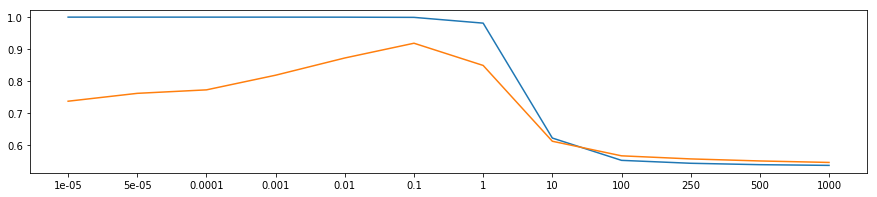

In [26]:
plt.figure(figsize=(15,3))
plt.plot(range(len(alpha_range)), tr_scores)
plt.plot(range(len(alpha_range)), cv_scores)
plt.xticks(range(len(alpha_range)), alpha_range)
plt.show()

In [27]:
# Creating the model with our best alpha.
clf = MultinomialNB(alpha = 0.1)
clf.fit(bow_train_data, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [28]:
# Feature importance :
pos, neg = feat_imp(bow_vectorizer.get_feature_names(), clf)

In [29]:
# Most important positive features
pos

,negative,positive
like,-5.069685,-5.142376
tast,-4.982898,-5.204391
good,-5.786438,-5.337161
flavor,-5.554138,-5.366018
love,-6.377245,-5.398610
great,-6.684763,-5.408381
use,-5.839779,-5.440163
tea,-5.998398,-5.480738
one,-5.487800,-5.487625
product,-5.209301,-5.578743


In [30]:
# Most important negative features:
neg

,negative,positive
tast,-4.982898,-5.204391
like,-5.069685,-5.142376
product,-5.209301,-5.578743
one,-5.487800,-5.487625
flavor,-5.554138,-5.366018
tri,-5.658582,-5.601457
would,-5.676105,-6.111865
good,-5.786438,-5.337161
use,-5.839779,-5.440163
coffe,-5.858902,-5.729073


Confusion Matrix : 


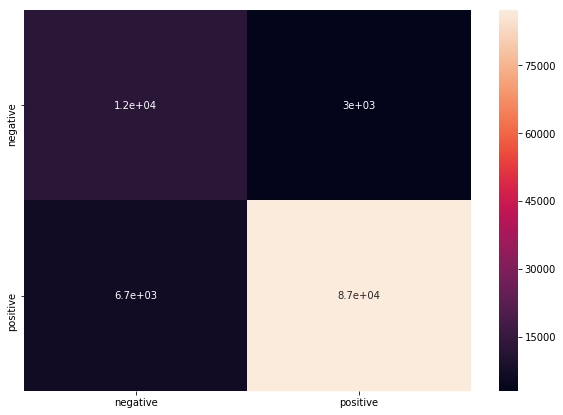

True Positives : 87175
False Positives : 6690
True Negatives : 12391
False Negatives : 2996


In [31]:
# Plotting the Confusion Matrix :
preds = clf.predict(bow_test_data)
plot_confusion_matrix(y_actual=np.array(y_test), y_predicted=preds)

#### Test Metrics :

In [32]:
rec = roc_auc_score(y_true=np.array(y_test), y_score=clf.predict_proba(bow_test_data)[:,1])
print("ROC_AUC Score : ", rec)

ROC_AUC Score :  0.9138160316238958


#### Conclusion for BOW :
1. The best value of alpha obtained was 0.1
2. There are many samples which are being classified as positives when they are not.
3. CV ROC_AUC Score : 0.9180
4. Test ROC_AUC score - 0.9138

### TFIDF :

In [33]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_train_data = tfidf_vectorizer.fit_transform(X_train['CleanedText'])
tfidf_train_data.shape

(178443, 1816552)

In [34]:
tfidf_cv_data = tfidf_vectorizer.transform(X_cv['CleanedText'])
tfidf_cv_data.shape

(76476, 1816552)

In [35]:
tfidf_test_data = tfidf_vectorizer.transform(X_test['CleanedText'])
tfidf_test_data.shape

(109252, 1816552)

In [36]:
# Hyperparameter tuning :
alpha_range = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 250, 500, 1000]
cv_scores = []
tr_scores = []
i = 0
for alpha in alpha_range:
    clf = MultinomialNB(alpha=alpha)
    clf.fit(tfidf_train_data, y_train)
    scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(tfidf_cv_data)[:,1])
    cv_scores.append(scores)
    scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(tfidf_train_data)[:,1])
    tr_scores.append(scores)
    print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], " For alpha : ", alpha)
    i += 1

CV ROC_AUC Score :  0.835971883190825  Train ROC_AUC Score :  0.999985949153685  For alpha :  1e-05
CV ROC_AUC Score :  0.8542553349600026  Train ROC_AUC Score :  0.9999844549600179  For alpha :  5e-05
CV ROC_AUC Score :  0.8633888412751396  Train ROC_AUC Score :  0.9999834164849849  For alpha :  0.0001
CV ROC_AUC Score :  0.8991470934700477  Train ROC_AUC Score :  0.9999754436261781  For alpha :  0.001
CV ROC_AUC Score :  0.9345516607207531  Train ROC_AUC Score :  0.9999251353670857  For alpha :  0.01
CV ROC_AUC Score :  0.9372942663242452  Train ROC_AUC Score :  0.997919945203995  For alpha :  0.1
CV ROC_AUC Score :  0.8230483416174079  Train ROC_AUC Score :  0.9104222598607614  For alpha :  1
CV ROC_AUC Score :  0.7274777342067029  Train ROC_AUC Score :  0.7520149274642798  For alpha :  10
CV ROC_AUC Score :  0.6771476890124701  Train ROC_AUC Score :  0.6821620011451972  For alpha :  100
CV ROC_AUC Score :  0.6649462365549824  Train ROC_AUC Score :  0.6674797372287226  For alpha :  

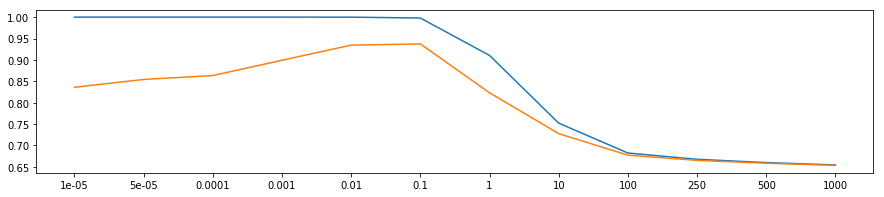

In [43]:
plt.figure(figsize=(15,3))
plt.plot(range(len(alpha_range)), tr_scores)
plt.plot(range(len(alpha_range)), cv_scores)
plt.xticks(range(len(alpha_range)), alpha_range)
plt.show()

In [37]:
# Creating the model with our best alpha.
clf = MultinomialNB(alpha = 0.1)
clf.fit(tfidf_train_data, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [38]:
# Feature importance :
pos, neg = feat_imp(tfidf_vectorizer.get_feature_names(), clf)

In [39]:
pos

,negative,positive
tea,-7.378621,-6.357042
great,-8.315337,-6.363863
love,-8.006603,-6.377128
tast,-6.664492,-6.417954
good,-7.445952,-6.430475
like,-6.805403,-6.430711
flavor,-7.167359,-6.496687
coffe,-7.175600,-6.530804
use,-7.548618,-6.602476
product,-6.826565,-6.606195


In [40]:
neg

,negative,positive
tast,-6.664492,-6.417954
like,-6.805403,-6.430711
product,-6.826565,-6.606195
would,-7.148533,-7.151804
flavor,-7.167359,-6.496687
one,-7.171364,-6.689112
coffe,-7.175600,-6.530804
tri,-7.293117,-6.747021
buy,-7.308018,-6.968220
order,-7.313068,-7.054089


Confusion Matrix : 


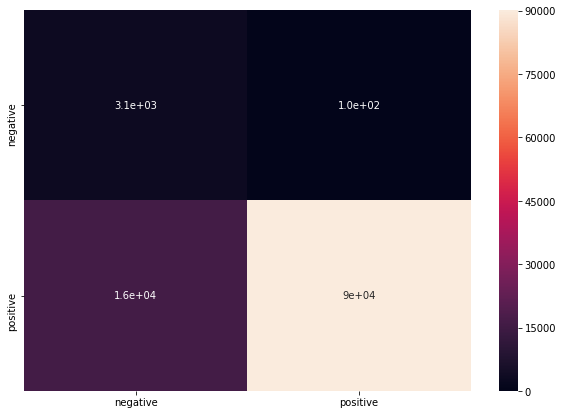

True Positives : 90066
False Positives : 15980
True Negatives : 3101
False Negatives : 105


In [41]:
# Plotting the Confusion Matrix :
preds = clf.predict(tfidf_test_data)
plot_confusion_matrix(y_actual=np.array(y_test), y_predicted=preds)

#### Test Metrics :

In [42]:
rec = roc_auc_score(y_true=np.array(y_test), y_score=clf.predict_proba(tfidf_test_data)[:,1])
print("ROC_AUC Score : ", rec)

ROC_AUC Score :  0.9339785395525755


#### Conclusion for TFIDF :
1. The best value of alpha obtained was 0.1
2. Number of false negatives is quite low as compared to the bow model.
3. CV ROC_AUC Score : 0.9372
4. Test ROC_AUC Score : 0.9339

## Conclusions :

<table>
    <tr><th>Multinomial Model with</th><th>Best value of alpha</th><th>Train metric (ROC_AUC)</th><th>CV metric (ROC_AUC)</th><th>Test metric (ROC_AUC)</th></tr>
    <tr><td>Bag of Words 2 grams</td> <td>0.1</td> <td>0.9991</td> <td>0.9180</td> <td>0.9138</td></tr>
    <tr><td>TFIDF 2 grams</td> <td>0.1</td> <td>0.9979</td> <td>0.9372</td> <td>0.9339</td></tr>
</table>